<div style='color:white;font-size:30px;background-color:#196363;text-align:center;padding-top:20px; padding-bottom:20px;margin-bottom:40px'>VERSIFICATION & AUTHORSHIP ATTRIBUTION</div>
<h1>3.3.2 Versification based vs. lexical based attribution</h1>
<h2 style='margin-bottom: 50px'>Replication code</h2>

In [15]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import sticho
from collections import defaultdict
from scipy import stats

<h3>Read data from JSON</h3>

In [16]:
#----------------------------------------------------------------------------------------------------------#
# Files contain a list of poems with following structure:                                                  #   
# [{                                                                                                       #
#    'author': string (name of the author),                                                                #
#    'title': string (title of the poem),                                                                  #
#    'subcorpus': int (id of the subcorpus to which the poem belongs)                                      #
#    'body': [{                                                                                            #
#        'text': string (text of the line)                                                                 #
#        'metre': string (metre of the line)                                                               #
#        'stress_pattern': string (bit string representing stressed/unstressed syllables)                  #
#        'rhyme': list (indices of lines with which this one rhymes)                                       #
#        'words': [{                                                                                       #
#            'token': string,                                                                              #
#            'lemma': string,                                                                              #
#            'tag': string (POS-tag)                                                                       #
#            'xsampa': string (phonetic transcription of word in XSampa)                                   #
#         }, ...]                                                                                          #
#     }, ... ]                                                                                             #
# }, ...]                                                                                                  #
#                                                                                                          #
# CZECH CORPUS                                                                                             #
# Dataset comes from The Corpus of Czech Verse (http://versologie.cz/v2/web_content/corpus.php?lang=en).   #
#                                                                                                          #
# SPANISH CORPUS                                                                                           #
# Dataset comes from Corpus de Sonetos del Siglo de Oro                                                    #
#    (https://github.com/bncolorado/CorpusSonetosSigloDeOro).                                              #
# Tokenization, lemmatization, pos-tagging provided by TreeTagger                                          #
#    (https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/).                                          #
# Phonetic transcription provided by ESpeak (http://espeak.sourceforge.net/)                               #
#                                                                                                          #
# GERMAN CORPUS                                                                                            #
# Dataset not published here as it comes from proprietary corpus Metricalizer (http://metricalizer.de).    #
#----------------------------------------------------------------------------------------------------------#

data = dict()
with open('data/cs.json', 'r') as f:
    data['cs'] = json.load(f)
with open('data/es.json', 'r') as f:
    data['es'] = json.load(f)
    
# Subcorpora available for each corpus
subcorpora = {'cs': (1,2,3), 'es': (1,2)}

<h3>Cross-validation</h3>

iteration #30 | mft = 150 | lang = cs | subc = 1              
	p(Wilcoxon) = 1.1442144430510537e-05
iteration #30 | mft = 250 | lang = cs | subc = 1              
	p(Wilcoxon) = 0.0002981699421895982
iteration #30 | mft = 500 | lang = cs | subc = 1              
	p(Wilcoxon) = 2.1577047385332823e-05
iteration #30 | mft = 150 | lang = cs | subc = 2              
	p(Wilcoxon) = 8.084788301662718e-06
iteration #30 | mft = 250 | lang = cs | subc = 2              
	p(Wilcoxon) = 7.61946721684823e-06
iteration #30 | mft = 500 | lang = cs | subc = 2              
	p(Wilcoxon) = 7.737777422379613e-05
iteration #30 | mft = 150 | lang = cs | subc = 3              
	p(Wilcoxon) = 1.5983101993404364e-06
iteration #30 | mft = 250 | lang = cs | subc = 3              
	p(Wilcoxon) = 1.6363965084210647e-06
iteration #30 | mft = 500 | lang = cs | subc = 3              
	p(Wilcoxon) = 1.5942375258103098e-06
iteration #30 | mft = 150 | lang = es | subc = 1              
	p(Wilcoxon) = 0.8724228556121767

/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")



	p(Wilcoxon) = 1.0
iteration #30 | mft = 150 | lang = es | subc = 2              
	p(Wilcoxon) = 0.15935193824976623
iteration #30 | mft = 250 | lang = es | subc = 2              
	p(Wilcoxon) = 0.2093193697720107
iteration #30 | mft = 500 | lang = es | subc = 2              
	p(Wilcoxon) = 0.7684977098758217


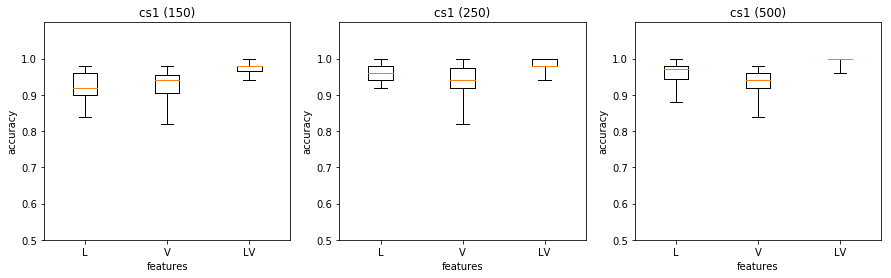

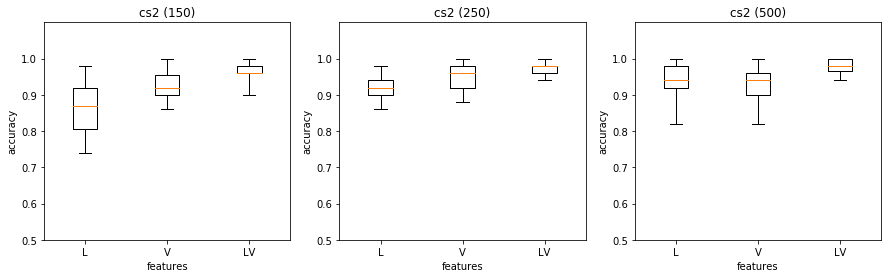

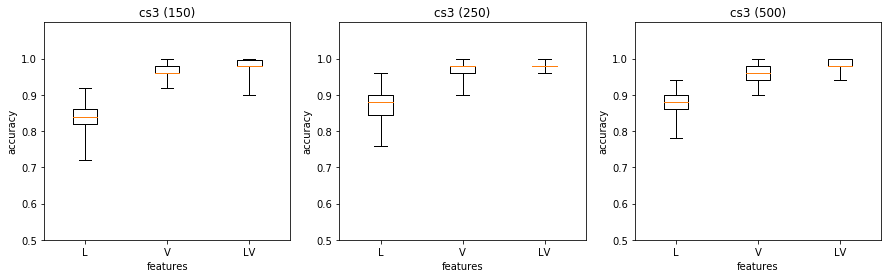

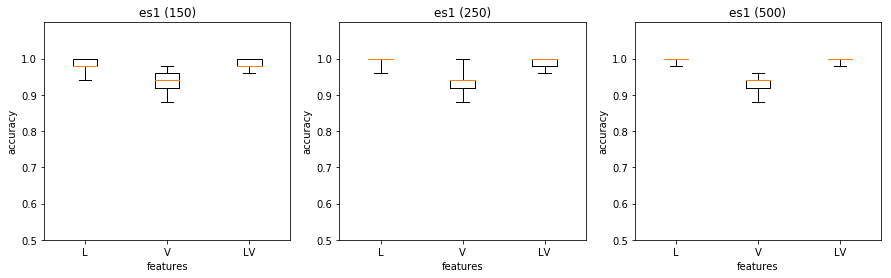

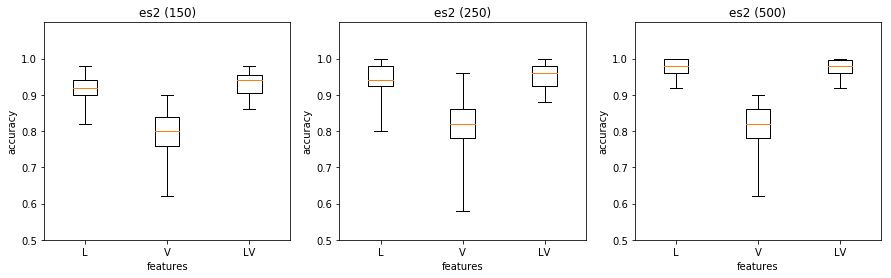

In [18]:
# Container to store predictions
decisions = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
acc = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Iterate over subcorpora
for lang in sorted(data):
    for subc in subcorpora[lang]:
        
        # Iterate over different mft settings
        for mft in (150, 250, 500):
           
            # Perform 30 iterations
            for iteration in range(30):            

                print('iteration #{0} | mft = {1} | lang = {2} | subc = {3}              '.format(
                    iteration+1, mft, lang, subc
                ), end='\r')

                # SAMPLING
                s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=40)
                # Select 5 authors by random
                s.level_authors(n=5)
                # Randomly select 10 samples by each author
                s.level_samples(max_=10)

                # CLASSIFICATION WITH LEMMATA
                f1 = sticho.Features(s)
                f1.bow(domain='lemma', mft=mft)
                f1.build_dataframe()
                # Cross-validation
                c = sticho.Classification(f1, clf='svm', kernel='linear', C=1)
                acc[mft][lang+str(subc)]['L'].append(c.cross_validation())
                for d in c.results['decisions']:
                    decisions[mft][lang+str(subc)][iteration]['L'].append((d[0], c.results['decisions'][d]))                    
                    
                # CLASSIFICATION WITH VERSIFICATION
                f2 = sticho.Features(s)    
                f2.rhythmic_ngrams(n=2, mft=0)
                f2.rhythmic_ngrams(n=3, mft=0)
                f2.rhythmic_ngrams(n=4, mft=0)
                f2.rhyme_profile(method='word_length', mft=0, ending='mf')
                f2.rhyme_profile(method='stress', mft=0, ending='mf')
                f2.rhyme_profile(method='pos', mft=0, ending='mf')
                f2.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=1)
                f2.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=2)
                f2.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=3)
                f2.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=4)
                f2.sound_frequencies(mft=30)
                f2.build_dataframe()    
                # Cross-validation
                c = sticho.Classification(f2, clf='svm', kernel='linear', C=1)
                acc[mft][lang+str(subc)]['V'].append(c.cross_validation())
                for d in c.results['decisions']:
                    decisions[mft][lang+str(subc)][iteration]['V'].append((d[0], c.results['decisions'][d]))
                
                # CLASSIFICATION WITH VERSIFICATION + LEMMATA 
                df3 = pd.concat([f1.df_, f2.df_], axis=1, sort=False)
                # Cross-validation
                c = sticho.Classification(df3, clf='svm', kernel='linear', C=1)
                acc[mft][lang+str(subc)]['LV'].append(c.cross_validation())                
                for d in c.results['decisions']:
                    decisions[mft][lang+str(subc)][iteration]['LV'].append((d[0], c.results['decisions'][d]))
                                
            # Wilcoxon signed rank test
            w = stats.wilcoxon(acc[mft][lang+str(subc)]['L'], acc[mft][lang+str(subc)]['LV'])
            print('\n\tp(Wilcoxon) = {0}'.format(w.pvalue))
                    
        # Plot the charts
        fig, axs = plt.subplots(1, 3, figsize=(15,4))
        plot_i = 0
        for mft in sorted(acc):
            axs[plot_i].boxplot([ 
                acc[mft][lang+str(subc)]['L'], 
                acc[mft][lang+str(subc)]['V'], 
                acc[mft][lang+str(subc)]['LV'] 
            ], whis=[0,100])
            axs[plot_i].set_ylim(0.5,1.1)
            axs[plot_i].set_xticklabels(['L', 'V', 'LV'])
            axs[plot_i].set_title('{0}{1} ({2})'.format(lang, subc, mft))
            axs[plot_i].set_yticks(axs[plot_i].get_yticks()[:-1])
            axs[plot_i].set_xlabel('features')
            axs[plot_i].set_ylabel('accuracy')
            plot_i += 1

<h3>Voting</h3>

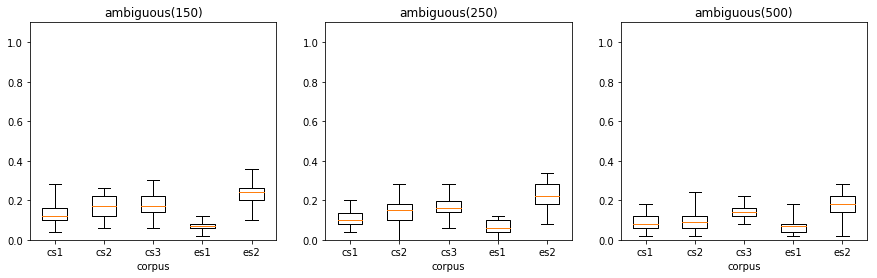

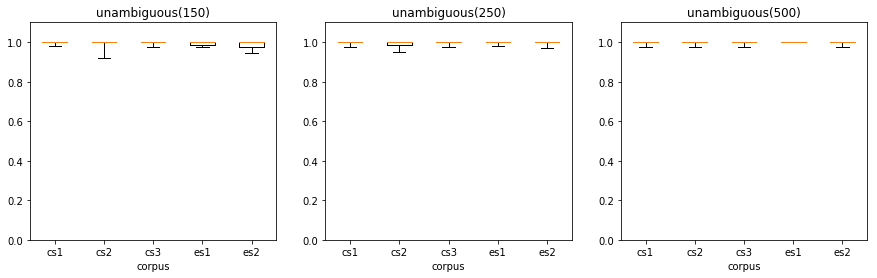

In [12]:
# Container for plotting data
plotdata = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Iterate over predictions from particular iterations
for mft in decisions:
    for subcorpus in decisions[mft]:
        for iteration in decisions[mft][subcorpus]:
            ambiguous = 0
            unambiguous_correct = 0
            for i, x in enumerate(decisions[mft][subcorpus][iteration]['L']):
                decision_l = decisions[mft][subcorpus][iteration]['L'][i]
                decision_v = decisions[mft][subcorpus][iteration]['V'][i]
                # Prediction by lemmata != prediction by versification
                if decision_l[1] != decision_v[1]:
                    ambiguous += 1
                # Both predict the same author and the prediction is correct
                elif decision_l[1] == decision_l[0]:
                    unambiguous_correct += 1
            # Store data to the main container
            plotdata['unambiguous'][mft][subcorpus].append(unambiguous_correct/(len(decisions[mft][subcorpus][iteration]['L']) - ambiguous))
            plotdata['ambiguous'][mft][subcorpus].append(ambiguous/len(decisions[mft][subcorpus][iteration]['L']))
            
# Iterate over plotting data (ambiguous/unambiguous)
for t in sorted(plotdata):
    # Plot the charts
    fig, axs = plt.subplots(1, 3, figsize=(15,4))
    plot_i = 0
    for mft in sorted(plotdata[t]):
        axs[plot_i].boxplot([ 
            plotdata[t][mft]['cs1'], 
            plotdata[t][mft]['cs2'], 
            plotdata[t][mft]['cs3'],
            plotdata[t][mft]['es1'],
            plotdata[t][mft]['es2']
        ], whis=[0,100])
        axs[plot_i].set_ylim(0,1.1)
        axs[plot_i].set_xticklabels(['cs1', 'cs2', 'cs3', 'es1', 'es2'])
        axs[plot_i].set_title('{0}({1})'.format(t, mft))
        axs[plot_i].set_yticks(axs[plot_i].get_yticks()[:-1])
        axs[plot_i].set_xlabel('corpus')
        plot_i += 1

In [19]:
# Print p-values
for mft in plotdata['unambiguous']:
    for subc in plotdata['unambiguous'][mft]:
        if sorted(plotdata['unambiguous'][mft][subc]) != sorted(acc[mft][subc]['L']):            
            w = stats.wilcoxon(plotdata['unambiguous'][mft][subc], acc[mft][subc]['L'])
            print(mft, subc, 'L', w.pvalue)
        if sorted(plotdata['unambiguous'][mft][subc]) != sorted(acc[mft][subc]['V']):            
            w = stats.wilcoxon(plotdata['unambiguous'][mft][subc], acc[mft][subc]['V'])
            print(mft, subc, 'V', w.pvalue)
        if sorted(plotdata['unambiguous'][mft][subc]) != sorted(acc[mft][subc]['LV']):            
            w = stats.wilcoxon(plotdata['unambiguous'][mft][subc], acc[mft][subc]['LV'])
            print(mft, subc, 'LV', w.pvalue)  

250 es2 L 1.8957631424603906e-05
250 es2 V 1.6678313975036149e-06
250 es2 LV 1.6897314186860455e-05
250 es1 L 0.009454332030834373
250 es1 V 2.3434959542201058e-06
250 es1 LV 0.0511998362745388
250 cs2 L 3.716291950908611e-06
250 cs2 V 2.584007955542239e-06
250 cs2 LV 1.2296882968809649e-05
250 cs1 L 3.2931495080422715e-06
250 cs1 V 2.3418941242887347e-06
250 cs1 LV 0.0001320456763959241
250 cs3 L 1.580051428024809e-06
250 cs3 V 2.875572273617061e-06
250 cs3 LV 4.124102095924912e-05
500 es2 L 0.0004698669578488691
500 es2 V 1.659399844033728e-06
500 es2 LV 0.00030607170265197994
500 es1 V 1.5312284726953685e-06
500 es1 LV 0.31731050786291415
500 cs2 L 7.338295563576314e-06
500 cs2 V 2.2974108281097315e-06
500 cs2 LV 0.00028352415776931704
500 cs1 L 5.503938136582391e-05
500 cs1 V 2.291113790811059e-06
500 cs1 LV 0.04108722452782128
500 cs3 L 1.6229293364132389e-06
500 cs3 V 1.0771899135604078e-05
500 cs3 LV 0.00025812880774004254
150 es2 L 2.3161206293822223e-06
150 es2 V 1.72134358939

/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
